# Plant disease classifier using leaf photos

### Using Pytorch library and ResNet model

**Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




**Imports**


In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import time
import copy
import os
from os import listdir
import zipfile



**Fetching Data**

In [ ]:
!git clone https://Jacob_Boesch@bitbucket.org/Jacob_Boesch/plant_leaf_classifier.git

In [ ]:
path = '/content/plant_leaf_classifier'
data_dir = os.path.join(path)
zip_file = zipfile.ZipFile(data_dir + "/images.zip", 'r')
zip_file.extractall('/tmp/images')
zip_file.close()

In [ ]:
!cd /tmp/images/PlantVillage/PlantVillage/ && ls

In [ ]:
TRAIN_DIR = os.path.join('/tmp/images/PlantVillage/PlantVillage/train')
VAL_DIR = os.path.join('/tmp/images/PlantVillage/PlantVillage/val')

**Creating Training Dataset**

In [ ]:
transform_train = transforms.Compose([
    #transforms.RandomCrop(128, padding_mode="reflect"),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
train_ds = torchvision.datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=transform_train
)

**Creating Validation Dataset**

In [ ]:
transform_val = transforms.Compose([
    transforms.Resize((224,224)),                                
    transforms.ToTensor()
])

val_ds = torchvision.datasets.ImageFolder(
    root=VAL_DIR,
    transform=transform_val

)

**Creating Dataloaders**

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
batch_size=32

**Displaying Sample Images**

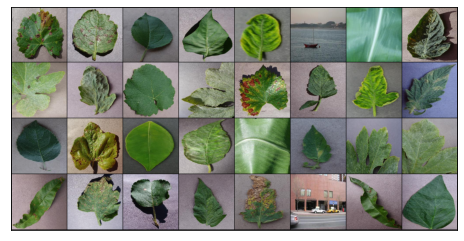

In [ ]:
from torchvision.utils import make_grid

def show_batch(train_dl):
    for images,_ in train_dl:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break
        
show_batch(train_dl)

**Configuring Device**

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda") #if the GPU is availble this method will return cuda.
    else:
        return torch.device("cpu")
    
def to_device(data, device): #in here we move the data to device of our choice, the GPU
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)
    
device = get_device()
device

device(type='cuda')

**Model**

In [ ]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out =self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, 104)
        
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self): #by freezing all the layers but the last one we allow it to warm up (the others are already good at training)
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True
            
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:
model = ResNet()
model

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
model = to_device(model, device)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

**Training Method**

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    
    history = []
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [ ]:
result = evaluate(model, val_dl) #let's check the model performance before training it
result

{'val_acc': 0.0031016403809189796, 'val_loss': 5.089087963104248}

**Freezing all layers except last layer**

In [ ]:
model.freeze()

In [ ]:
epochs = 15
max_lr = 10e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

**Training**

In [ ]:
from tqdm.notebook import tqdm

history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)


Epoch: [1/15], last_lr: 0.0002, train_loss: 0.3124, val_loss: 0.1954, val_acc: 0.9482



Epoch: [2/15], last_lr: 0.0004, train_loss: 0.1471, val_loss: 0.1381, val_acc: 0.9585



Epoch: [3/15], last_lr: 0.0008, train_loss: 0.1647, val_loss: 0.2623, val_acc: 0.9170



Epoch: [4/15], last_lr: 0.0010, train_loss: 0.1554, val_loss: 0.3246, val_acc: 0.9050



Epoch: [5/15], last_lr: 0.0010, train_loss: 0.1349, val_loss: 0.2658, val_acc: 0.9166



Epoch: [6/15], last_lr: 0.0010, train_loss: 0.1104, val_loss: 0.2665, val_acc: 0.9268



Epoch: [7/15], last_lr: 0.0009, train_loss: 0.0945, val_loss: 0.0747, val_acc: 0.9772



Epoch: [8/15], last_lr: 0.0008, train_loss: 0.0728, val_loss: 0.0761, val_acc: 0.9748



Epoch: [9/15], last_lr: 0.0006, train_loss: 0.0549, val_loss: 0.0740, val_acc: 0.9758



Epoch: [10/15], last_lr: 0.0005, train_loss: 0.0400, val_loss: 0.0576, val_acc: 0.9826



Epoch: [11/15], last_lr: 0.0003, train_loss: 0.0257, val_loss: 0.0247, val_acc: 0.9922



Epoch: [12/15], last_lr: 0.0002, train_loss: 0.0152, val_loss: 0.0157, val_acc: 0.9953



Epoch: [13/15], last_lr: 0.0001, train_loss: 0.0079, val_loss: 0.0109, val_acc: 0.9966



Epoch: [14/15], last_lr: 0.0000, train_loss: 0.0044, val_loss: 0.0094, val_acc: 0.9972



Epoch: [15/15], last_lr: 0.0000, train_loss: 0.0028, val_loss: 0.0088, val_acc: 0.9974


In [ ]:
model.unfreeze()

**Plots**

Text(0, 0.5, 'Loss')

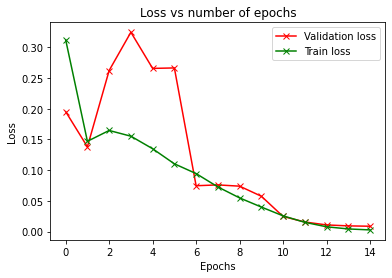

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

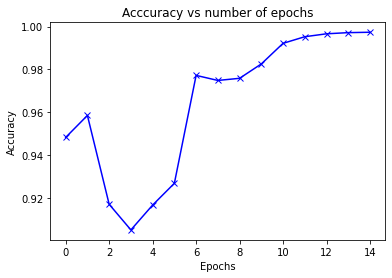

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

**Saving the model**

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ModelFinal.pth')

**Testing our model**

In [ ]:
model = ResNet()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ModelFinal.pth'))

<All keys matched successfully>

In [ ]:
model.eval()

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor()
])

In [ ]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/test.JPG')

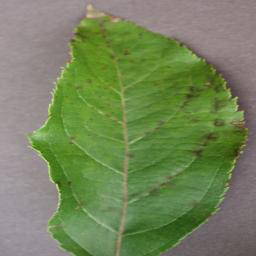

In [ ]:
image

In [ ]:
temp = transform_test(image)

In [ ]:
temp = temp.unsqueeze(0)

In [ ]:
out = model(temp)

In [ ]:
_, pred = torch.max(out, 1) 

In [ ]:
pred

tensor([0])